# ARMA task
Learn an autoregressive moving average model (see Wikipedia for an introduction if unfamiliar) for at least 5 individual sensors (pick them in a sensible way!). Most statistical packages (R, statsmodels in Python) contain standard algorithm for fitting these models from training data. Use autocorrelation plots in order to identify the order of the ARMA models. The parameters can be determined using Akaike’s Information Criterion (AIC) or another model selection method. Note that there exists a wide range of ARMA variants; you only have to use the basic model.

Decide how to set the detection threshold sensibly. Study some of the anomalies detected anomalies. What kind of anomalies can you detect using ARMA models? Which sensors can be modeled effectively using ARMA?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [2]:
def parse_date(x):    
    date = str(x).split(' ')[0]
    time_stamp = pd.datetime.strptime(date,'%d/%m/%y')
    return time_stamp
df_1 = pd.read_csv('BATADAL_dataset_training_1.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_2 = pd.read_csv('BATADAL_dataset_training_2.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_3 = pd.read_csv('BATADAL_test_dataset.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_1.head()

,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
0,2014-01-06,0.509730,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
1,2014-01-06,0.412580,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0
2,2014-01-06,0.320112,1.986093,4.140192,3.256733,3.574601,5.500000,2.246126,98.420959,1,...,91.056114,26.487364,86.582474,19.597170,83.988579,19.496712,72.425293,29.354538,28.454538,0
3,2014-01-06,0.332879,2.009203,4.673478,3.744497,3.952379,5.500000,3.203573,97.575172,1,...,92.594353,26.575815,88.020546,26.028486,64.670486,25.922703,76.275040,29.449951,28.549952,0
4,2014-01-06,0.483496,2.089049,5.237937,4.409456,3.504676,5.500000,4.439714,97.351059,1,...,94.473099,26.723457,90.422462,26.209970,64.746620,26.104692,76.703529,29.574265,28.674263,0


## Check autocorrelation
Apply Durbin Watson test to examine autocorrelation in the data. The test will return a value between 0 and 4.
- A value of 2.0 means there is no autocorrelation detected in the sample. 
- Values from zero to 2.0 indicate positive autocorrelation.
- Values from 2.0 to 4.0 indicate negative autocorrelation.

In [9]:
sm.stats.durbin_watson(df_1['L_T1'])

0.006432171620535719

## Identifying the order of differencing(d) in ARIMA model

In [15]:
result = adfuller(df_1['L_T3'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.375782
p-value: 0.000000


## Diagnosing ACF and PACF plots

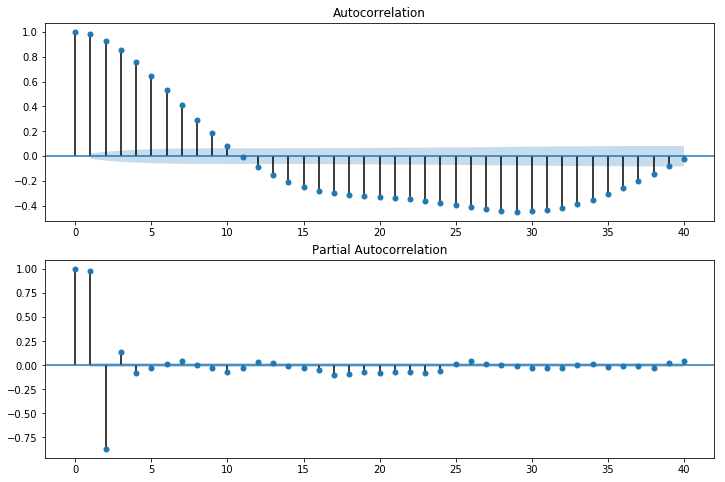

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_1['L_T1'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_1['L_T1'], lags=40, ax=ax2)

### Apply ARIMA

[ 1.67974472 -1.21129745  0.46422101 -0.28146945]
[-0.58074841 -0.05513937]


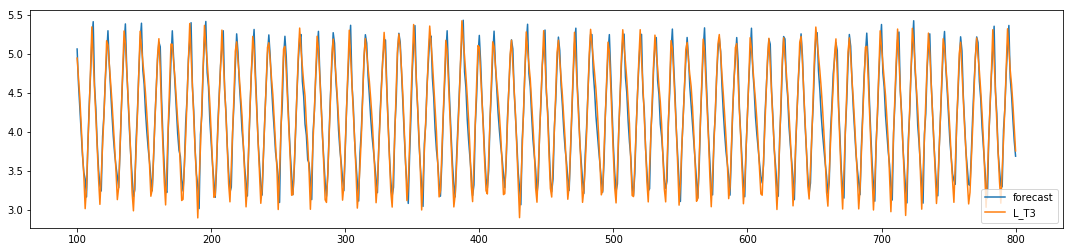

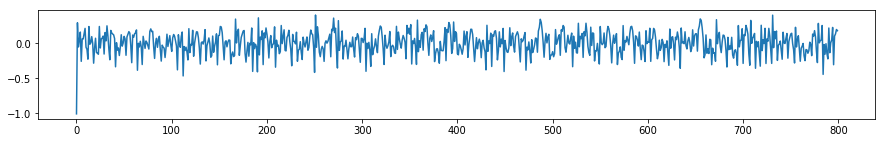

In [3]:
model = ARIMA(df_1['L_T3'], order=(4,0,2))
model_fit = model.fit(disp=0)
# print(model_fit.summary())
print(model_fit.arparams)
print(model_fit.maparams)

# Actual vs Fitted
fig = model_fit.plot_predict(dynamic=False, start=100, end=800)
fig.set_size_inches(18.5, 4)
plt.show()

# Plot residual
plt.figure(figsize=(15,2))
plt.plot(model_fit.resid[0:800])
plt.show()


In [22]:
def grid_search(data):
    best_order = None
    best_score = float('Inf')
    for p in range(0, 6):
        for d in range(0, 2):
            for q in range(0, 4):
                order = (p, d, q)
                try:
                    model = ARIMA(data, order=order)
                    model_fit = model.fit(disp=0, trend='nc')
                    aic = model_fit.aic
                    print('ARIMA%s AIC=%.3f' % (order,aic))
                    
                    if (aic < best_score):
                        best_order = order
                        best_score = aic
                except:
                    continue
    
    print('Best ARIMA%s AIC=%.3f' % (best_order, best_score))

In [23]:
grid_search(df_1['L_T3'])

ARIMA(0, 0, 1) AIC=38456.054
ARIMA(0, 1, 1) AIC=2556.822
ARIMA(0, 1, 3) AIC=668.917
ARIMA(1, 0, 0) AIC=7878.319
ARIMA(1, 0, 1) AIC=2537.836
ARIMA(1, 0, 2) AIC=652.784
ARIMA(1, 0, 3) AIC=2167.369
ARIMA(1, 1, 0) AIC=1654.185
ARIMA(1, 1, 1) AIC=7186.397
ARIMA(2, 0, 0) AIC=1556.620
ARIMA(2, 0, 1) AIC=657.878
ARIMA(2, 1, 0) AIC=236.059
ARIMA(2, 1, 3) AIC=-7326.300
ARIMA(3, 0, 0) AIC=196.690
ARIMA(3, 0, 3) AIC=-7278.234
ARIMA(3, 1, 0) AIC=-216.990


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 1, 3) AIC=-7382.666
ARIMA(4, 0, 0) AIC=-239.217


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(4, 0, 3) AIC=-5394.524
ARIMA(4, 1, 0) AIC=-1856.638
ARIMA(4, 1, 2) AIC=-7579.337
ARIMA(5, 0, 0) AIC=-1861.376


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 2) AIC=-7450.007
ARIMA(5, 1, 0) AIC=-4093.213
ARIMA(5, 1, 2) AIC=-7432.344
Best ARIMA(4, 1, 2) AIC=-7579.337


predicted=8.349, observed=5.238, previous=4.673, residual=3.111
predicted=7.470, observed=5.156, previous=5.238, residual=2.315
predicted=6.960, observed=4.984, previous=5.156, residual=1.976
predicted=6.951, observed=4.747, previous=4.984, residual=2.204
predicted=6.215, observed=4.418, previous=4.747, residual=1.797
predicted=5.786, observed=4.130, previous=4.418, residual=1.655
predicted=5.457, observed=3.665, previous=4.130, residual=1.792
predicted=4.402, observed=3.267, previous=3.665, residual=1.134
predicted=4.233, observed=3.015, previous=3.267, residual=1.218
predicted=3.890, observed=3.487, previous=3.015, residual=0.403
predicted=5.878, observed=4.016, previous=3.487, residual=1.861
predicted=5.914, observed=4.468, previous=4.016, residual=1.447
predicted=6.935, observed=4.969, previous=4.468, residual=1.967
predicted=7.563, observed=5.228, previous=4.969, residual=2.335
predicted=7.469, observed=4.881, previous=5.228, residual=2.588
predicted=6.166, observed=4.479, previou

predicted=3.937, observed=3.026, previous=3.218, residual=0.912
predicted=4.169, observed=3.485, previous=3.026, residual=0.684
predicted=5.700, observed=3.926, previous=3.485, residual=1.774
predicted=5.730, observed=4.411, previous=3.926, residual=1.319
predicted=6.967, observed=4.815, previous=4.411, residual=2.153
predicted=7.077, observed=5.233, previous=4.815, residual=1.844
predicted=7.946, observed=4.988, previous=5.233, residual=2.958
predicted=6.200, observed=4.535, previous=4.988, residual=1.665
predicted=6.056, observed=4.069, previous=4.535, residual=1.986
predicted=5.009, observed=3.616, previous=4.069, residual=1.393
predicted=4.543, observed=3.167, previous=3.616, residual=1.375
predicted=3.845, observed=3.257, previous=3.167, residual=0.588
predicted=5.007, observed=3.724, previous=3.257, residual=1.283
predicted=5.708, observed=4.203, previous=3.724, residual=1.505
predicted=6.427, observed=4.794, previous=4.203, residual=1.634
predicted=7.535, observed=5.341, previou

predicted=7.102, observed=4.951, previous=4.383, residual=2.151
predicted=7.483, observed=5.200, previous=4.951, residual=2.283
predicted=7.437, observed=4.945, previous=5.200, residual=2.492
predicted=6.446, observed=4.709, previous=4.945, residual=1.737
predicted=6.503, observed=4.568, previous=4.709, residual=1.935
predicted=6.150, observed=4.303, previous=4.568, residual=1.847
predicted=5.612, observed=3.996, previous=4.303, residual=1.616
predicted=5.253, observed=3.672, previous=3.996, residual=1.580
predicted=4.705, observed=3.153, previous=3.672, residual=1.552
predicted=3.656, observed=3.123, previous=3.153, residual=0.533
predicted=4.734, observed=3.561, previous=3.123, residual=1.172
predicted=5.481, observed=3.966, previous=3.561, residual=1.515
predicted=5.933, observed=4.439, previous=3.966, residual=1.494
predicted=6.914, observed=4.893, previous=4.439, residual=2.021
predicted=7.319, observed=5.378, previous=4.893, residual=1.941
predicted=8.189, observed=4.967, previou

predicted=7.004, observed=5.201, previous=4.749, residual=1.803
predicted=7.947, observed=4.995, previous=5.201, residual=2.952
predicted=6.262, observed=4.630, previous=4.995, residual=1.632
predicted=6.323, observed=4.263, previous=4.630, residual=2.061
predicted=5.383, observed=3.799, previous=4.263, residual=1.584
predicted=4.728, observed=3.336, previous=3.799, residual=1.391
predicted=4.119, observed=3.075, previous=3.336, residual=1.044
predicted=4.081, observed=3.454, previous=3.075, residual=0.627
predicted=5.588, observed=3.902, previous=3.454, residual=1.686
predicted=5.749, observed=4.361, previous=3.902, residual=1.388
predicted=6.798, observed=4.815, previous=4.361, residual=1.983
predicted=7.231, observed=5.269, previous=4.815, residual=1.962
predicted=7.966, observed=5.017, previous=5.269, residual=2.949
predicted=6.249, observed=4.782, previous=5.017, residual=1.467
predicted=6.814, observed=4.481, previous=4.782, residual=2.333
predicted=5.625, observed=4.227, previou

predicted=7.507, observed=5.237, previous=4.917, residual=2.270
predicted=7.586, observed=4.992, previous=5.237, residual=2.594
predicted=6.439, observed=4.680, previous=4.992, residual=1.759
predicted=6.377, observed=4.523, previous=4.680, residual=1.854
predicted=6.120, observed=4.238, previous=4.523, residual=1.882
predicted=5.451, observed=3.817, previous=4.238, residual=1.633
predicted=4.826, observed=3.412, previous=3.817, residual=1.413
predicted=4.304, observed=3.006, previous=3.412, residual=1.297
predicted=3.671, observed=3.403, previous=3.006, residual=0.267
predicted=5.761, observed=3.889, previous=3.403, residual=1.872
predicted=5.634, observed=4.463, previous=3.889, residual=1.170
predicted=7.200, observed=4.948, previous=4.463, residual=2.252
predicted=7.327, observed=5.197, previous=4.948, residual=2.130
predicted=7.550, observed=4.828, previous=5.197, residual=2.722
predicted=5.984, observed=4.462, previous=4.828, residual=1.522
predicted=6.094, observed=4.147, previou

predicted=8.067, observed=5.023, previous=5.215, residual=3.044
predicted=6.244, observed=4.657, previous=5.023, residual=1.587
predicted=6.432, observed=4.284, previous=4.657, residual=2.148
predicted=5.368, observed=3.944, previous=4.284, residual=1.424
predicted=5.182, observed=3.578, previous=3.944, residual=1.604
predicted=4.478, observed=3.232, previous=3.578, residual=1.246
predicted=4.141, observed=3.209, previous=3.232, residual=0.933
predicted=4.624, observed=3.630, previous=3.209, residual=0.994
predicted=5.706, observed=4.057, previous=3.630, residual=1.649
predicted=6.041, observed=4.538, previous=4.057, residual=1.503
predicted=7.066, observed=5.036, previous=4.538, residual=2.030
predicted=7.598, observed=5.350, previous=5.036, residual=2.248
predicted=7.785, observed=5.058, previous=5.350, residual=2.727
predicted=6.426, observed=4.859, previous=5.058, residual=1.567
predicted=6.901, observed=4.689, previous=4.859, residual=2.212
predicted=6.149, observed=4.460, previou

predicted=6.768, observed=4.843, previous=4.323, residual=1.925
predicted=7.387, observed=5.260, previous=4.843, residual=2.127
predicted=7.817, observed=5.024, previous=5.260, residual=2.793
predicted=6.384, observed=4.838, previous=5.024, residual=1.546
predicted=6.907, observed=4.671, previous=4.838, residual=2.236
predicted=6.124, observed=4.419, previous=4.671, residual=1.705
predicted=5.901, observed=4.071, previous=4.419, residual=1.830
predicted=5.207, observed=3.709, previous=4.071, residual=1.498
predicted=4.773, observed=3.259, previous=3.709, residual=1.514
predicted=3.924, observed=3.049, previous=3.259, residual=0.875
predicted=4.209, observed=3.508, previous=3.049, residual=0.701
predicted=5.722, observed=4.025, previous=3.508, residual=1.697
predicted=6.010, observed=4.340, previous=4.025, residual=1.671
predicted=6.460, observed=4.767, previous=4.340, residual=1.693
predicted=7.323, observed=5.239, previous=4.767, residual=2.084
predicted=7.844, observed=4.975, previou

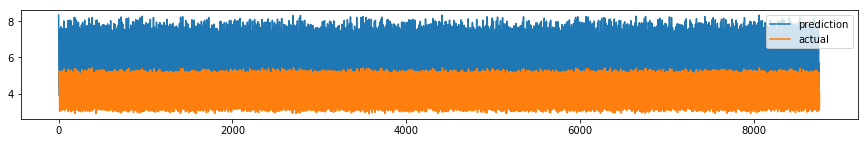

In [18]:
training_data = df_1['L_T3']
testing_data = df_3['L_T3']

avg = training_data.mean()
ar_coef = model_fit.arparams
ma_coef = model_fit.maparams
residuals = model_fit.resid.tolist()
# history = training_data.tolist()
prediction = []

def predict(coef, arr):
    yhat = 0.0
    for i in range(1, len(coef) + 1):
        yhat += coef[i - 1] * arr[-i]
#         print("arr[-%d]=%f" % (i, arr[-i]))
    return yhat

def prepare(predataset, history):
    for t in range(len(predataset)):
        history.append(predataset[t])
    return history

# Get the threshold from training data
def train_threshold(train, history, p):
    for i in range(p, len(train)+p):
        yhat = predict(ar_coef, history) + predict(ma_coef, residuals) + history[-1]
        observed = train[i]
        history.append(observed)
        error = abs(yhat-observed)
        residuals.append(error)
        prediction.append(yhat)
        print('predicted=%.3f, observed=%.3f, previous=%.3f, residual=%.3f' % (yhat, observed, history[-2], error))

    # Plot prediction vs actual
    plt.figure(figsize=(15,2))
    plt.plot(prediction, label='prediction')
    plt.plot(train, label='actual')
    plt.legend()
    plt.show()
    
    threshold = max(residuals)
    return threshold

p = 4
pretrain, train = training_data[0:p], training_data[p:]
history = prepare(pretrain.tolist(), training_data.tolist())
threshold = train_threshold(train, history, p)

In [22]:
pretest, test = testing_data[0:p], testing_data[p:]
history = prepare(pretest.tolist(), history)

def predict_anomaly(threshold, history, test, p):
    ar_coef = model_fit.arparams
    ma_coef = model_fit.maparams    
    residuals = model_fit.resid.tolist()
    
    anomaly = list()
    
    for i in range(p, len(test)+p):
        yhat = predict(ar_coef, history) + predict(ma_coef, residuals) + history[-1]
        observed = train[i]
        history.append(observed)
        error = abs(yhat-observed)
        residuals.append(error)
        prediction.append(yhat)
#         print('predicted=%.3f, observed=%.3f, previous=%.3f, residual=%.3f' % (yhat, observed, history[-2], error))
        
        if error > threshold:
            anomaly.append(p)
            print('DETECTED residual=%.3f at t=%d' % (error, p))
    
    print(anomaly)
    
predict_anomaly(threshold, history, test, 4)

DETECTED residual=3.521 at t=4
[4]
